In [1]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from tqdm import tqdm
import sqlite3 as sl
import os

In [2]:
%load_ext autoreload
%autoreload 2

## Read Data

In [3]:
import pandas as pd

In [5]:
config = load_config_and_check("../config/qmt_v07.yaml")

# Quick check EDA 

In [8]:
con = sl.connect(os.path.join(config["experiment_folder"], "qfl.db"))
df = pd.read_sql("""SELECT * FROM QFLDATA""", con)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33518 entries, 0 to 33517
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            33518 non-null  int64  
 1   program_id                       33518 non-null  object 
 2   time_exec                        33518 non-null  float64
 3   source.program_id                33518 non-null  object 
 4   source.selected_gate_set         33518 non-null  object 
 5   source.selected_optimization     33518 non-null  object 
 6   source.shots                     33518 non-null  int64  
 7   source.n_qubits                  33518 non-null  int64  
 8   source.n_ops                     33518 non-null  int64  
 9   source.opt_level                 33518 non-null  int64  
 10  source.target_gates              0 non-null      object 
 11  source.py_file_path              33518 non-null  object 
 12  source.time_genera

In [9]:
[c for c in df.columns if "time" in c]

['time_exec',
 'source.time_generation',
 'followup.time_generation',
 'followup.time_metamorph',
 'followup.metamorphic_times',
 'divergence.ks.time']

In [14]:
df.iloc[2]["followup.metamorphic_strategies"]

"['change_backend', 'change_coupling_map']"

In [13]:
df.iloc[2]["followup.metamorphic_times"]

'[0.0056653739884495735, 0.00462045194581151]'

# Create aggregated data

In [21]:
df_time = df[[
    'program_id',
    'time_exec',
    'source.time_generation',
    'followup.time_generation',
    'followup.time_metamorph',
    'divergence.ks.time'
]]

df_time.head()

,program_id,time_exec,source.time_generation,followup.time_generation,followup.time_metamorph,divergence.ks.time
0,702666942a78493cb86c73e446e32ac2,0.405335,0.005364,0.005364,0.019991,0.011086
1,d16a9864a4b2409fb2bc35f7aeb803be,0.944097,0.009761,0.009761,0.054740,0.027485
2,49ef7ae2154f40ea813c51d18c22b748,0.711311,0.009808,0.009808,0.032950,0.019987
3,4dd1f272ac834f9683a98dd9ca0daa2e,0.846428,0.009944,0.009944,0.040833,0.010125
4,1c5a1506bf6d4f4fbd6ca8f48c49903c,0.508497,0.008455,0.008455,0.038247,0.005185


In [22]:
df_time_melt = pd.melt(
    df_time, id_vars=['program_id'], value_vars=[
    'time_exec',
    'source.time_generation',
    'followup.time_generation',
    'followup.time_metamorph',
    'divergence.ks.time'
])
df_time_melt.head(20)

,program_id,variable,value
0,702666942a78493cb86c73e446e32ac2,time_exec,0.405335
1,d16a9864a4b2409fb2bc35f7aeb803be,time_exec,0.944097
2,49ef7ae2154f40ea813c51d18c22b748,time_exec,0.711311
3,4dd1f272ac834f9683a98dd9ca0daa2e,time_exec,0.846428
4,1c5a1506bf6d4f4fbd6ca8f48c49903c,time_exec,0.508497
5,79dee27a8c59446783516420799f5b06,time_exec,0.547088
6,86fc143a1862412d83e006a368c3a74c,time_exec,0.514013
7,f2e3864864ed4866bc6d1e9b1d403afd,time_exec,0.355561
8,366e20be9acc4e2c9e72c378309f4b29,time_exec,0.512701
9,2f950659d2e74811a0c090df3f06aeeb,time_exec,0.636736


# Visualize Aggregated Data

<AxesSubplot:xlabel='value', ylabel='variable'>

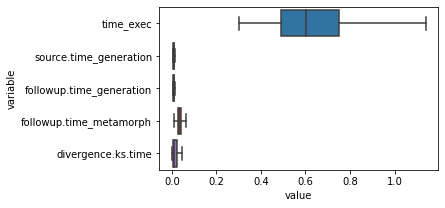

In [34]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.boxplot(
    data=df_time_melt,
    y='variable',
    x='value',
    showfliers=False,
    ax=ax
)